<a href="https://colab.research.google.com/github/akritidu/Multi-label-Classification-in-the-Home-Improvement/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"/content/drive/MyDrive/Dataset/HMDataset.csv"

'/content/drive/MyDrive/Dataset/HMDataset.csv'

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/HMDataset.csv")

In [ ]:
df.head()

,id,contexts,categories
0,1,!Hi - this junction box was covered with a plu...,"['electrical', 'wiring']"
1,2,"""High efficiency"" & condensing boilers or furn...","['hvac', 'appliances', 'interior-maintenance']"
2,3,"""We moved the microwave to a different spot in...","['electrical', 'wiring']"
3,4,(An update is below the pictures.)We just move...,"['plumbing', 'hvac']"
4,5,(Apologies in advance folks - I'm new to compr...,"['plumbing', 'materials', 'appliances']"


In [ ]:
df.drop(['id'],axis=1,inplace=True)
df.head()

,contexts,categories
0,!Hi - this junction box was covered with a plu...,"['electrical', 'wiring']"
1,"""High efficiency"" & condensing boilers or furn...","['hvac', 'appliances', 'interior-maintenance']"
2,"""We moved the microwave to a different spot in...","['electrical', 'wiring']"
3,(An update is below the pictures.)We just move...,"['plumbing', 'hvac']"
4,(Apologies in advance folks - I'm new to compr...,"['plumbing', 'materials', 'appliances']"


In [ ]:
from ast import literal_eval
df['categories'] = df.categories.apply(lambda x: literal_eval(str(x)))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.categories)
# Getting a sense of how the tags data looks like
print(y[4])
print(mlb.inverse_transform(y[4].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 1 1 0 0 0]
[('appliances', 'materials', 'plumbing')]
['appliances' 'electrical' 'exterior-maintenance' 'hardware-tools' 'hvac'
 'insulation' 'interior-maintenance' 'lighting' 'materials' 'plumbing'
 'safety' 'walls-drywallls' 'wiring']


In [ ]:
df1 = pd.DataFrame(y, columns = ['appliances', 'electrical', 'exterior-maintenance', 'hardware-tools', 'hvac', 'insulation', 'interior-maintenance', 'lighting', 'materials', 'plumbing', 'safety', 'walls-drywallls', 'wiring'] )
df1.head()

,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
df = df.merge(df1, left_index=True, right_index=True)
df.head()

,contexts,categories,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,!Hi - this junction box was covered with a plu...,"[electrical, wiring]",0,1,0,0,0,0,0,0,0,0,0,0,1
1,"""High efficiency"" & condensing boilers or furn...","[hvac, appliances, interior-maintenance]",1,0,0,0,1,0,1,0,0,0,0,0,0
2,"""We moved the microwave to a different spot in...","[electrical, wiring]",0,1,0,0,0,0,0,0,0,0,0,0,1
3,(An update is below the pictures.)We just move...,"[plumbing, hvac]",0,0,0,0,1,0,0,0,0,1,0,0,0
4,(Apologies in advance folks - I'm new to compr...,"[plumbing, materials, appliances]",1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
df.drop(['categories'],axis=1,inplace=True)
df.head()

,contexts,appliances,electrical,exterior-maintenance,hardware-tools,hvac,insulation,interior-maintenance,lighting,materials,plumbing,safety,walls-drywallls,wiring
0,!Hi - this junction box was covered with a plu...,0,1,0,0,0,0,0,0,0,0,0,0,1
1,"""High efficiency"" & condensing boilers or furn...",1,0,0,0,1,0,1,0,0,0,0,0,0
2,"""We moved the microwave to a different spot in...",0,1,0,0,0,0,0,0,0,0,0,0,1
3,(An update is below the pictures.)We just move...,0,0,0,0,1,0,0,0,0,1,0,0,0
4,(Apologies in advance folks - I'm new to compr...,1,0,0,0,0,0,0,0,1,1,0,0,0


In [ ]:
target = ['appliances', 'electrical', 'exterior-maintenance', 'hardware-tools', 'hvac', 'insulation', 'interior-maintenance', 'lighting', 'materials', 'plumbing', 'safety', 'walls-drywallls', 'wiring']

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 61 kB 493 kB/s 
     |████████████████████████████████| 3.3 MB 32.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['contexts']
        self.targets = self.df[target].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [ ]:
train_size = 0.8
training_df = df.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_df = df.drop(training_df.index).reset_index(drop=True)
training_df = training_df.reset_index(drop=True)

In [ ]:
train_data = CustomDataset(training_df, tokenizer, MAX_LEN)
valid_data = CustomDataset(validation_df, tokenizer, MAX_LEN)

In [ ]:
training_data_loader = torch.utils.data.DataLoader(train_data, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

validation_data_loader = torch.utils.data.DataLoader(valid_data, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 13)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
loss_values, validation_loss_values = [], []
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('*********** Epoch {}: Training Begins   ***********'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('*********** Epoch {}: Training Terminated     ***********'.format(epoch))
    
    print('*********** Epoch {}: Validation Begins   ***********'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('*********** Epoch {}: Validation Terminated  ***********'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      loss_values.append( train_loss)
      valid_loss = valid_loss/len(validation_loader)
      validation_loss_values.append( valid_loss)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('*********** Epoch {}  Done  ***********\n'.format(epoch))

  return model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Dataset/multi-label/curr_ckpt"
best_model_path = "/content/drive/MyDrive/Dataset/multi-label/best_model.pt"

In [ ]:
bert_trained_model = train_model(EPOCHS, training_data_loader, validation_data_loader, model, optimizer, checkpoint_path, best_model_path)

*********** Epoch 1: Training Begins   ***********
*********** Epoch 1: Training Terminated     ***********
*********** Epoch 1: Validation Begins   ***********
*********** Epoch 1: Validation Terminated  ***********
Epoch: 1 	Avgerage Training Loss: 0.000641 	Average Validation Loss: 0.001830
Validation loss decreased (inf --> 0.001830).  Saving model ...
*********** Epoch 1  Done  ***********

*********** Epoch 2: Training Begins   ***********
*********** Epoch 2: Training Terminated     ***********
*********** Epoch 2: Validation Begins   ***********
*********** Epoch 2: Validation Terminated  ***********
Epoch: 2 	Avgerage Training Loss: 0.000415 	Average Validation Loss: 0.001422
Validation loss decreased (0.001830 --> 0.001422).  Saving model ...
*********** Epoch 2  Done  ***********

*********** Epoch 3: Training Begins   ***********
*********** Epoch 3: Training Terminated     ***********
*********** Epoch 3: Validation Begins   ***********
*********** Epoch 3: Validation Term

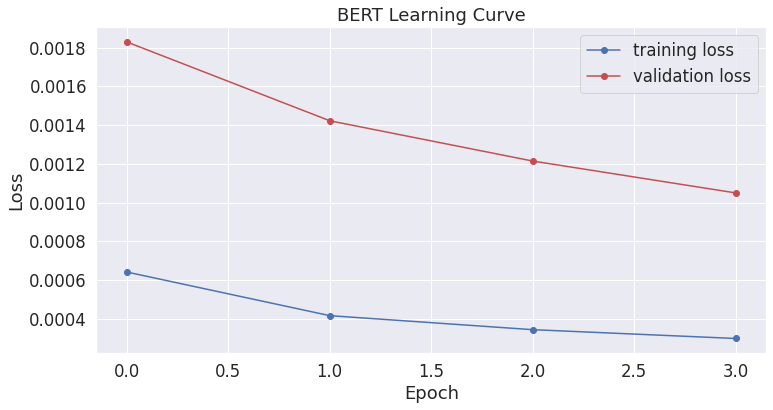

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("BERT Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig("/content/drive/MyDrive/Dataset/LOSS_bert_main(1).png", format="png", bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
val_preds = (np.array(val_outputs) > 0.3).astype(int)
val_preds

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
val_preds = np.array(val_outputs)
val_preds

array([[0.04551538, 0.0666332 , 0.43364304, ..., 0.21946229, 0.15178588,
        0.06279746],
       [0.14063461, 0.06714501, 0.10379338, ..., 0.21712747, 0.09321919,
        0.05439222],
       [0.100921  , 0.03976823, 0.25254095, ..., 0.18661419, 0.072179  ,
        0.02710162],
       ...,
       [0.01690376, 0.01741923, 0.01977553, ..., 0.04688621, 0.18242668,
        0.01107222],
       [0.11459473, 0.12441552, 0.02331043, ..., 0.01603878, 0.02112409,
        0.20717499],
       [0.03012319, 0.12835066, 0.04032803, ..., 0.02443896, 0.02443081,
        0.09129257]])

In [ ]:
val_targets = np.array(val_targets)
val_targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_targets[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_targets.ravel(), val_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


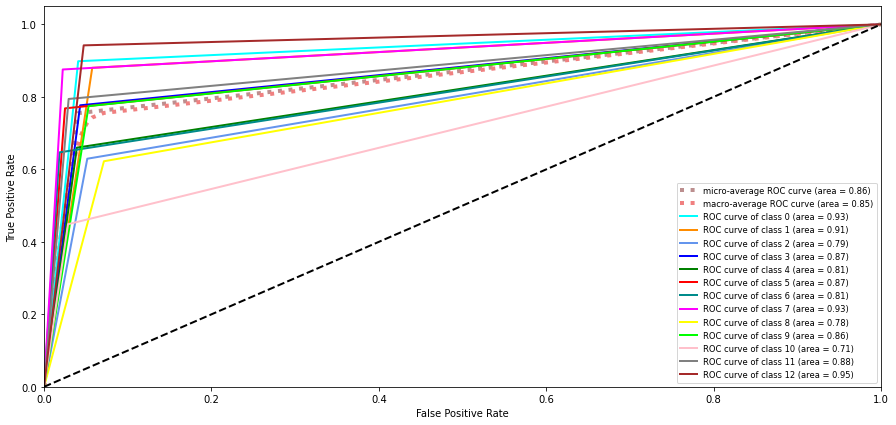

<function matplotlib.pyplot.close>

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rc('legend',fontsize=5) # using a size in points
plt.rc('legend',fontsize='small')

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_bert.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly

plt.show()
plt.close

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('AUC score: {}'.format(roc_auc_score(val_targets, val_preds)))

In [ ]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(val_targets, val_preds, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='samples'))) 

micro: 0.59
macro: 0.59 
weighted: 0.59 
sample: 0.70 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
import matplotlib
n_classes = y.shape[1]
matplotlib.rc('figure', figsize=(15, 7))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_targets[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(val_targets.ravel(), val_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


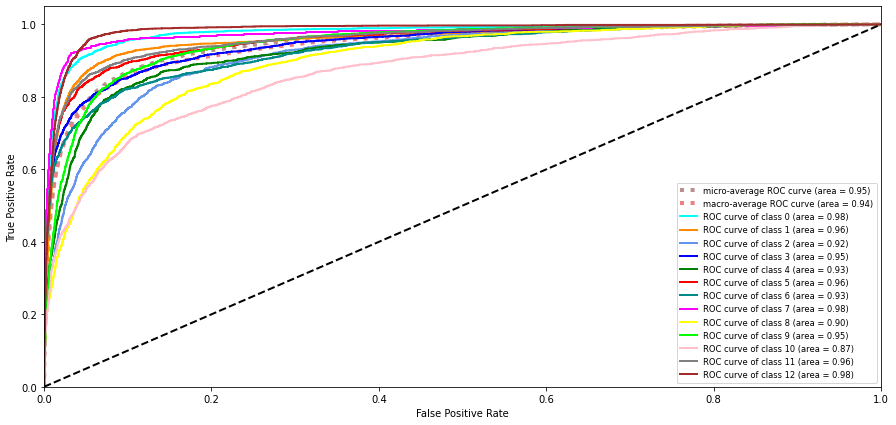

<function matplotlib.pyplot.close>

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='rosybrown', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='lightcoral', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'green', 'red', 'darkcyan', 'magenta', 'yellow', 'lime', 'pink', 'gray', 'brown', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rc('legend',fontsize=5) # using a size in points
plt.rc('legend',fontsize='small')

plt.savefig("/content/drive/MyDrive/Dataset/aucroc_bert_1.png", format="png", bbox_inches='tight', dpi=600) # specify filetype explicitly

plt.show()
plt.close

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
print('AUC score: {}'.format(roc_auc_score(val_targets, val_preds)))

AUC score: 0.9423250779425876


In [ ]:

from sklearn import metrics
from sklearn.metrics import average_precision_score
print("micro: {:.2f}".format(metrics.average_precision_score(val_targets, val_preds, average='micro')))
print("macro: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='macro')))
print("weighted: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='weighted')))
print("sample: {:.2f} ".format( metrics.average_precision_score(val_targets, val_preds, average='samples'))) 

micro: 0.81
macro: 0.79 
weighted: 0.80 
sample: 0.86 


In [ ]:
https://ieeexplore.ieee.org/document/9378266*


In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9031463

In [ ]:
https://arxiv.org/pdf/1811.01727.pdf

In [ ]:

1. paper 1
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9558977
https://github.com/scorpio11/Multi-label-Classification

In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=93782668*

In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9231498

In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8525817

In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9010667*

In [ ]:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9212992*